### Imports

In [31]:
import pandas as pd 
import seaborn as sns 
import random
import math
import matplotlib.pyplot as plt

### Generate test data

In [32]:
#This function generates test data for stars with ra, dec and magnitude for "plate" data and "gaia" data

random.seed(1)
n = 1000 #number of stars
i = 0
dt = [] #ideal
dt1 = [] #plate(apt)
dt2 = [] #"truth" (gaia)
er = 0.1 #deviation from "ideal" data

#for same number of stars
while i < n:
    dt.append([round(random.uniform(1,10), 2),round(random.uniform(1,10), 2),round(random.uniform(5,15), 2)])
    dt1.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    dt2.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    i+=1

df_apt = pd.DataFrame(dt1, columns = ['CentroidRA', 'CentroidDec', 'Magnitude'])
df_gaia = pd.DataFrame(dt2, columns = ['ra', 'dec','phot_bp_mean_mag']) 

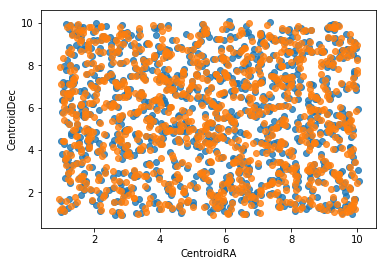

In [33]:
sns.regplot('ra','dec',data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec',data=df_apt, fit_reg = False)

### Combined data
- Combine data based on similarities between ra&dec
- Create new combined data
- Delete overlapping terms

In [34]:
m = 0
maxdiff = 0.5
df_gaia = df_gaia.sort_values('ra').reset_index(drop=True)
df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff'])

while m < len(df_apt):#apt
    n = 0
    df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
    while n<len(df_gaia):#gaia
        if df_apt['CentroidRA'][m] - maxdiff > df_gaia['ra'][n]: 
            n+=1
        elif df_apt['CentroidRA'][m] - maxdiff <= df_gaia['ra'][n] <= df_apt['CentroidRA'][m] + maxdiff :
            if df_apt['CentroidDec'][m] - maxdiff <= df_gaia['dec'][n] <= df_apt['CentroidDec'][m] + maxdiff :
                df_temp = df_temp.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n], \
                                          'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                                          'diff':  math.sqrt((df_gaia['ra'][n]-df_apt['CentroidRA'][m])**2+\
                                                             (df_gaia['dec'][n]-df_apt['CentroidDec'][m])**2)},\
                                         ignore_index=True)
            n+=1
        else :
            break
    if m == 0:
        print('Program started. \nProgress:')
    elif m == int(len(df_apt)/10):
        print(' 10% | ██--------------')
    elif m == int(len(df_apt)/4):
        print(' 25% | ████------------')
    elif m == int(len(df_apt)/2):
        print(' 50% | ████████--------')
    elif m == int(len(df_apt)/4*3):
        print(' 75% | ████████████----')
    elif m == len(df_apt)-1:
        print('100% | ████████████████ ✓')
    if df_temp.empty == False : 
        df_temp = df_temp.nsmallest(1, 'diff').reset_index(drop=True)
        df = df.append({'ra': df_temp['ra'][0], \
                    'dec': df_temp['dec'][0],\
                    'phot_bp_mean_mag': df_temp['phot_bp_mean_mag'][0],\
                    'CentroidRA': df_apt['CentroidRA'][m],\
                    'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': df_temp['diff'][0]}, ignore_index=True)
    m+=1
    
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
print("Number of matches: ", len(df))

Program started. 
Progress:
 10% | ██--------------
 25% | ████------------
 50% | ████████--------
 75% | ████████████----
100% | ████████████████ ✓
Number of matches:  501


/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

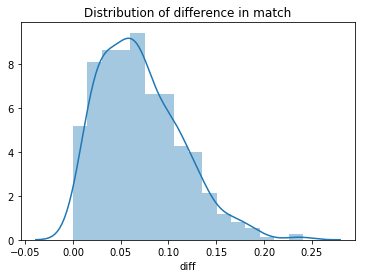

In [37]:
#Check match
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [40]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 

#subset
df_filtered = df.query('diff<0.15')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

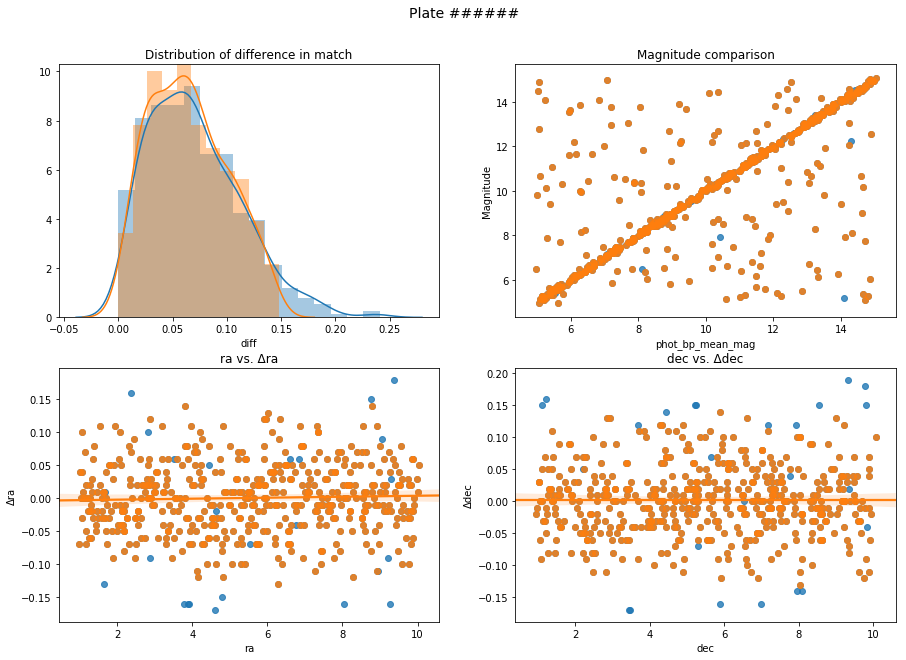

In [47]:
#plots
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate ######", fontsize=14)
fig.subplots_adjust(top=0.9, wspace=0.2)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
sns.distplot(df_filtered['diff'])

ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered, fit_reg = False).set_title('Magnitude comparison')

ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df, fit_reg = False).set_title('ra vs. Δra')
sns.regplot('ra','Δra',data=df_filtered).set_title('ra vs. Δra')

ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df, fit_reg = False).set_title('dec vs. Δdec')
sns.regplot('dec','Δdec',data=df_filtered).set_title('dec vs. Δdec')